<a href="https://colab.research.google.com/github/Loki-33/TS/blob/main/Time_series_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

In [3]:
from statsmodels.datasets import co2

In [5]:
co2_data = co2.load_pandas().data

In [6]:
co2_data.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [7]:
import matplotlib.pyplot as plt

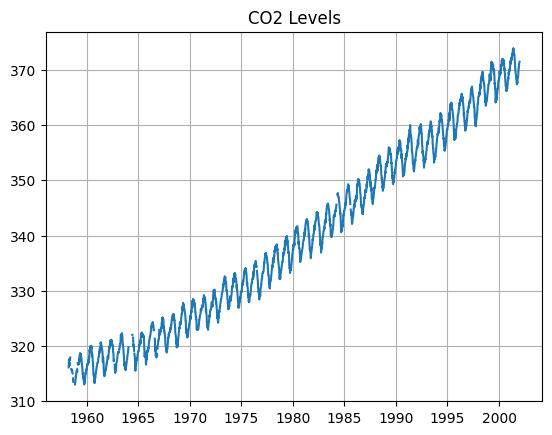

In [8]:
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
plt.title('CO2 Levels')
plt.plot(co2_data['co2'])
plt.grid(True)
plt.show()

In [11]:
np.int64

numpy.int64

In [44]:
co2_data['co2'].shift(5).values

array([  nan,   nan,   nan, ..., 368.8, 369.7, 370.3])

In [106]:
label_col = 'y'
data = pd.DataFrame(co2_data['co2'].copy())
data.columns = [label_col]

for i in range(1,53):
  data['lag_{}'.format(i)]= data[label_col].shift(i)

# days=['Mon', 'Tue', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
# months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'July', 'Aug', "Sep", "Oct", "Nov", 'Dec']
data['weekday'] = data.index.weekday
data['month'] = data.index.month
data['year'] = data.index.year
data['weekofyear'] = data.index.isocalendar().week
data['week_sin'] = np.sin(2 * np.pi * data['weekofyear'] / 52)
data['week_cos'] = np.cos(2 * np.pi * data['weekofyear'] / 52)
data['rolling_mean_52'] = data['y'].rolling(window=52).mean()
data['rolling_std_52'] = data['y'].rolling(window=52).std()
data = data.dropna()
data.head()

,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50,lag_51,lag_52,weekday,month,year,weekofyear,week_sin,week_cos,rolling_mean_52,rolling_std_52
1960-08-20,315.1,316.7,316.6,317.3,317.9,318.4,318.6,318.1,319.0,319.4,320.0,319.4,320.0,320.0,319.8,319.9,319.7,319.0,319.0,319.3,318.6,317.7,318.0,317.7,316.9,317.0,317.4,316.9,316.6,316.6,316.5,316.7,316.4,315.7,315.7,315.8,315.6,315.0,315.1,315.2,314.8,314.4,314.1,313.4,313.4,313.1,313.0,313.5,313.5,313.9,314.4,314.1,315.0,5,8,1960,33,-0.748511,-0.663123,316.728846,2.150270
1960-08-27,314.7,315.1,316.7,316.6,317.3,317.9,318.4,318.6,318.1,319.0,319.4,320.0,319.4,320.0,320.0,319.8,319.9,319.7,319.0,319.0,319.3,318.6,317.7,318.0,317.7,316.9,317.0,317.4,316.9,316.6,316.6,316.5,316.7,316.4,315.7,315.7,315.8,315.6,315.0,315.1,315.2,314.8,314.4,314.1,313.4,313.4,313.1,313.0,313.5,313.5,313.9,314.4,314.1,5,8,1960,34,-0.822984,-0.568065,316.740385,2.137459
1960-09-03,314.7,314.7,315.1,316.7,316.6,317.3,317.9,318.4,318.6,318.1,319.0,319.4,320.0,319.4,320.0,320.0,319.8,319.9,319.7,319.0,319.0,319.3,318.6,317.7,318.0,317.7,316.9,317.0,317.4,316.9,316.6,316.6,316.5,316.7,316.4,315.7,315.7,315.8,315.6,315.0,315.1,315.2,314.8,314.4,314.1,313.4,313.4,313.1,313.0,313.5,313.5,313.9,314.4,5,9,1960,35,-0.885456,-0.464723,316.746154,2.131414
1960-09-10,314.5,314.7,314.7,315.1,316.7,316.6,317.3,317.9,318.4,318.6,318.1,319.0,319.4,320.0,319.4,320.0,320.0,319.8,319.9,319.7,319.0,319.0,319.3,318.6,317.7,318.0,317.7,316.9,317.0,317.4,316.9,316.6,316.6,316.5,316.7,316.4,315.7,315.7,315.8,315.6,315.0,315.1,315.2,314.8,314.4,314.1,313.4,313.4,313.1,313.0,313.5,313.5,313.9,5,9,1960,36,-0.935016,-0.354605,316.757692,2.117281
1960-09-17,314.2,314.5,314.7,314.7,315.1,316.7,316.6,317.3,317.9,318.4,318.6,318.1,319.0,319.4,320.0,319.4,320.0,320.0,319.8,319.9,319.7,319.0,319.0,319.3,318.6,317.7,318.0,317.7,316.9,317.0,317.4,316.9,316.6,316.6,316.5,316.7,316.4,315.7,315.7,315.8,315.6,315.0,315.1,315.2,314.8,314.4,314.1,313.4,313.4,313.1,313.0,313.5,313.5,5,9,1960,37,-0.970942,-0.239316,316.771154,2.098303


In [107]:
lag_cols = [col for col in data.columns if 'lag' in col]
data['rolling_mean'] = data[lag_cols].mean(axis=1)
data['rolling_mean_12'] = data[label_col].rolling(12).mean()
y = data[label_col].values
data = data.drop(label_col, axis=1)

X = data.values
feature_names = data.columns
print('Dimension: ', X.shape)
data.head()

Dimension:  (1761, 62)


,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50,lag_51,lag_52,weekday,month,year,weekofyear,week_sin,week_cos,rolling_mean_52,rolling_std_52,rolling_mean,rolling_mean_12
1960-08-20,316.7,316.6,317.3,317.9,318.4,318.6,318.1,319.0,319.4,320.0,319.4,320.0,320.0,319.8,319.9,319.7,319.0,319.0,319.3,318.6,317.7,318.0,317.7,316.9,317.0,317.4,316.9,316.6,316.6,316.5,316.7,316.4,315.7,315.7,315.8,315.6,315.0,315.1,315.2,314.8,314.4,314.1,313.4,313.4,313.1,313.0,313.5,313.5,313.9,314.4,314.1,315.0,5,8,1960,33,-0.748511,-0.663123,316.728846,2.150270,316.726923,NaN
1960-08-27,315.1,316.7,316.6,317.3,317.9,318.4,318.6,318.1,319.0,319.4,320.0,319.4,320.0,320.0,319.8,319.9,319.7,319.0,319.0,319.3,318.6,317.7,318.0,317.7,316.9,317.0,317.4,316.9,316.6,316.6,316.5,316.7,316.4,315.7,315.7,315.8,315.6,315.0,315.1,315.2,314.8,314.4,314.1,313.4,313.4,313.1,313.0,313.5,313.5,313.9,314.4,314.1,5,8,1960,34,-0.822984,-0.568065,316.740385,2.137459,316.728846,NaN
1960-09-03,314.7,315.1,316.7,316.6,317.3,317.9,318.4,318.6,318.1,319.0,319.4,320.0,319.4,320.0,320.0,319.8,319.9,319.7,319.0,319.0,319.3,318.6,317.7,318.0,317.7,316.9,317.0,317.4,316.9,316.6,316.6,316.5,316.7,316.4,315.7,315.7,315.8,315.6,315.0,315.1,315.2,314.8,314.4,314.1,313.4,313.4,313.1,313.0,313.5,313.5,313.9,314.4,5,9,1960,35,-0.885456,-0.464723,316.746154,2.131414,316.740385,NaN
1960-09-10,314.7,314.7,315.1,316.7,316.6,317.3,317.9,318.4,318.6,318.1,319.0,319.4,320.0,319.4,320.0,320.0,319.8,319.9,319.7,319.0,319.0,319.3,318.6,317.7,318.0,317.7,316.9,317.0,317.4,316.9,316.6,316.6,316.5,316.7,316.4,315.7,315.7,315.8,315.6,315.0,315.1,315.2,314.8,314.4,314.1,313.4,313.4,313.1,313.0,313.5,313.5,313.9,5,9,1960,36,-0.935016,-0.354605,316.757692,2.117281,316.746154,NaN
1960-09-17,314.5,314.7,314.7,315.1,316.7,316.6,317.3,317.9,318.4,318.6,318.1,319.0,319.4,320.0,319.4,320.0,320.0,319.8,319.9,319.7,319.0,319.0,319.3,318.6,317.7,318.0,317.7,316.9,317.0,317.4,316.9,316.6,316.6,316.5,316.7,316.4,315.7,315.7,315.8,315.6,315.0,315.1,315.2,314.8,314.4,314.1,313.4,313.4,313.1,313.0,313.5,313.5,5,9,1960,37,-0.970942,-0.239316,316.771154,2.098303,316.757692,NaN


In [108]:
def train_test_split(X, y, test_size):
  test_index = int(len(X) * (1-test_size))
  X_train = X[:test_index]
  X_test = X[test_index:]
  y_train = y[:test_index]
  y_test = y[test_index:]
  return X_train, X_test, y_train, y_test

def mean_absolute_percentage_error(y_true, y_pred):
  return np.mean(np.abs(y_true - y_pred)/y_true)*100

In [109]:
def plot_results(X, y, test_size=0.3, plot_intervals=False, plot_anomalies=False):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size)
  model = RandomForestRegressor(max_depth=6, n_estimators=50)
  model.fit(X_train, y_train)
  prediction = model.predict(X_test)

  plt.figure(figsize=(15,7))

  x = range(prediction.size)
  plt.plot(x, prediction, label='prediction', linewidth=2.0)
  plt.plot(x, y_test, label='actual', linewidth=2.0)
  if plot_intervals:
    ts = TimeSeriesSplit(n_splits=5)
    cv = cross_val_score(model, X_train, y_train,
                         cv=ts, scoring='neg_mean_absolute_error')
    mae = -1 * cv.mean()
    deviation = cv.std()

    scale = 1.96
    margin_error = mae+scale*deviation
    lower=prediction-margin_error
    upper=prediction+margin_error

    fill_alpha=0.2
    fill_color = '#66C2D7'
    plt.fill_between(x, lower, upper, color=fill_color, alpha=fill_alpha, label='95% CI')

    if plot_anomalies:
      anomalies = np.array([np.nan]*len(y_test))
      anomalies[y_test < lower] = y_test[y_test < lower]
      anomalies[y_test > upper] = y_test[y_test > upper]
      plt.plot(x, anomalies, 'o', markersize=10, label='Anomalies')
  error = mean_absolute_percentage_error(y_test, prediction)
  plt.title('Mean absolute percentage error: {:.2f}%'.format(error))
  plt.legend(loc='best')
  plt.tight_layout()
  plt.grid(True)

  return model

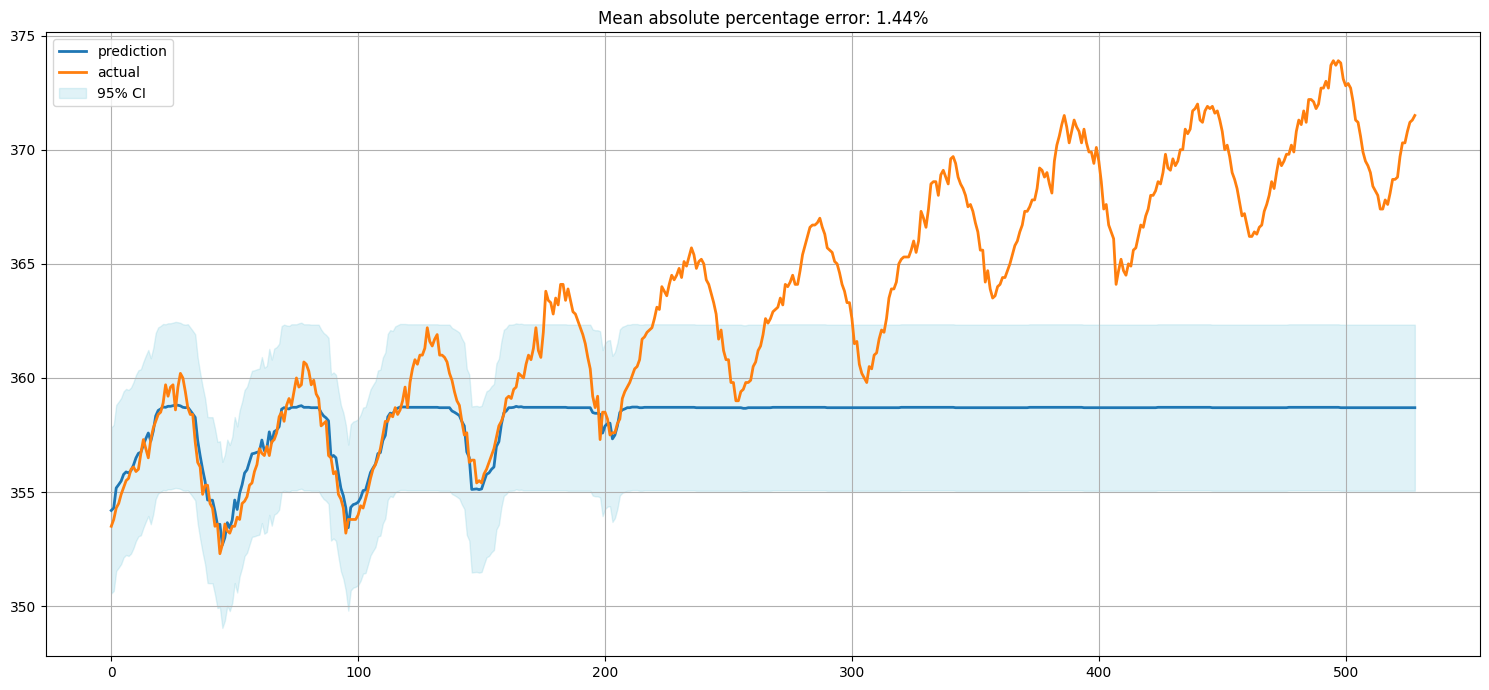

In [110]:
model = plot_results(X, y, plot_intervals=True)

In [111]:
columns = data.columns

In [112]:
column_importance = {}

In [113]:
for i in range(len(columns)):
  column_importance[columns[i]] = round(model.feature_importances_[i].item(), 3)

In [114]:
sorted(column_importance.items(), key=lambda x: x[1], reverse=True)

[('lag_1', 0.501),
 ('lag_52', 0.455),
 ('lag_51', 0.038),
 ('lag_2', 0.005),
 ('lag_3', 0.0),
 ('lag_4', 0.0),
 ('lag_5', 0.0),
 ('lag_6', 0.0),
 ('lag_7', 0.0),
 ('lag_8', 0.0),
 ('lag_9', 0.0),
 ('lag_10', 0.0),
 ('lag_11', 0.0),
 ('lag_12', 0.0),
 ('lag_13', 0.0),
 ('lag_14', 0.0),
 ('lag_15', 0.0),
 ('lag_16', 0.0),
 ('lag_17', 0.0),
 ('lag_18', 0.0),
 ('lag_19', 0.0),
 ('lag_20', 0.0),
 ('lag_21', 0.0),
 ('lag_22', 0.0),
 ('lag_23', 0.0),
 ('lag_24', 0.0),
 ('lag_25', 0.0),
 ('lag_26', 0.0),
 ('lag_27', 0.0),
 ('lag_28', 0.0),
 ('lag_29', 0.0),
 ('lag_30', 0.0),
 ('lag_31', 0.0),
 ('lag_32', 0.0),
 ('lag_33', 0.0),
 ('lag_34', 0.0),
 ('lag_35', 0.0),
 ('lag_36', 0.0),
 ('lag_37', 0.0),
 ('lag_38', 0.0),
 ('lag_39', 0.0),
 ('lag_40', 0.0),
 ('lag_41', 0.0),
 ('lag_42', 0.0),
 ('lag_43', 0.0),
 ('lag_44', 0.0),
 ('lag_45', 0.0),
 ('lag_46', 0.0),
 ('lag_47', 0.0),
 ('lag_48', 0.0),
 ('lag_49', 0.0),
 ('lag_50', 0.0),
 ('weekday', 0.0),
 ('month', 0.0),
 ('year', 0.0),
 ('weekofyear

In [115]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [120]:
co2_data

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4
...,...
2001-12-01,370.3
2001-12-08,370.8
2001-12-15,371.2
2001-12-22,371.3


In [147]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(co2)
print("ADF Statistic:", result[0])
print("p-value:", result[1])


ADF Statistic: 0.04605110843812055
p-value: 0.9621787846784349


In [132]:
co2 = co2_data['co2']
co2 = co2.fillna(method='ffill')


/tmp/ipython-input-339690538.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  co2 = co2.fillna(method='ffill')


In [138]:
import matplotlib.pyplot as plt

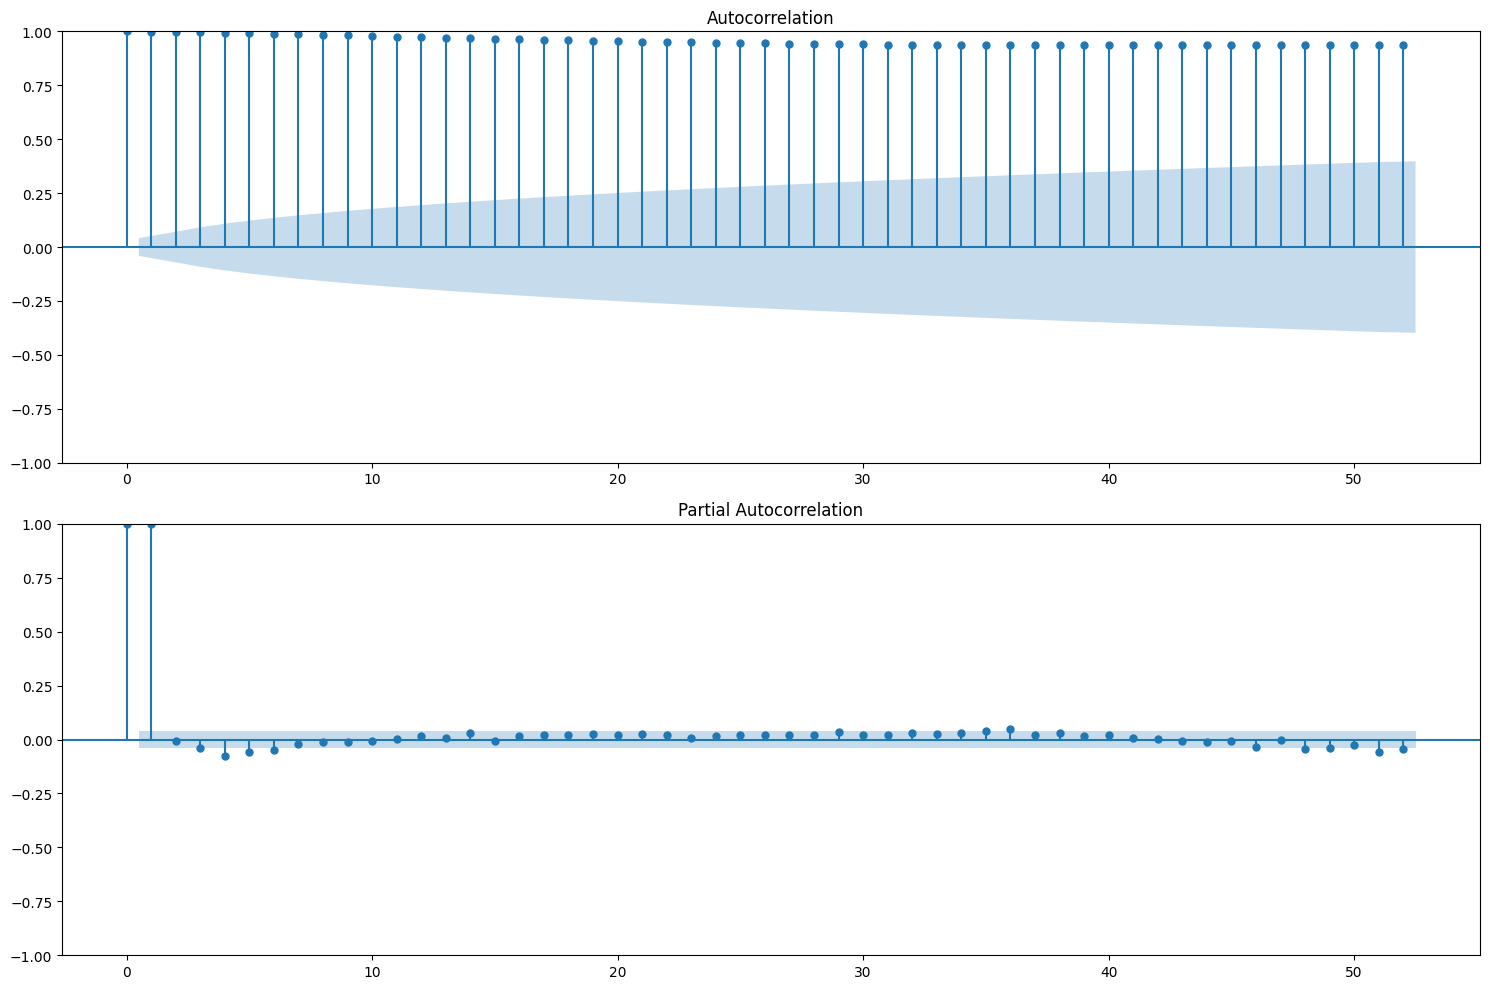

In [140]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
plot_acf(co2, lags=52, ax=axes[0])
plot_pacf(co2, lags=52, ax=axes[1])
fig.tight_layout()

In [141]:
co2_diff = co2.diff().dropna()

In [153]:
result2 = adfuller(co2_diff)
print("ADF Statistic:", result2[0])
print("p-value:", result2[1])


ADF Statistic: -15.517472045988958
p-value: 2.3063609140309003e-28


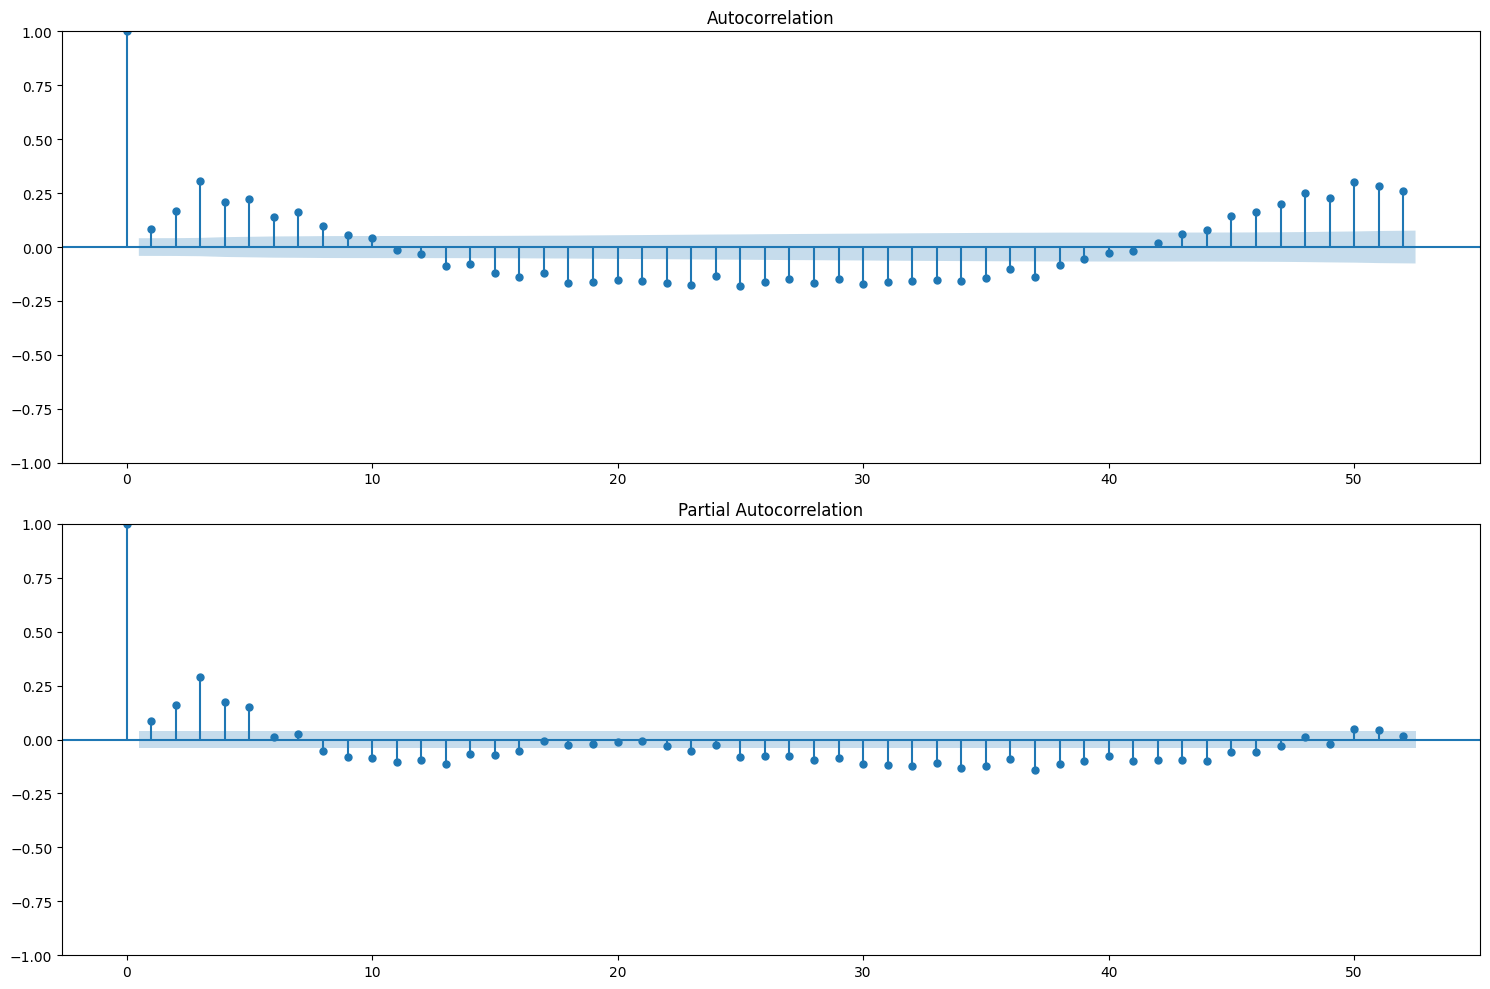

In [142]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
plot_acf(co2_diff, lags=52, ax=axes[0])
plot_pacf(co2_diff, lags=52, ax=axes[1])
fig.tight_layout()

In [ ]:
# the above plot shows theres seasonlity in the dataset

In [148]:
co2_diff1 = co2.diff(1).diff(52).dropna()R

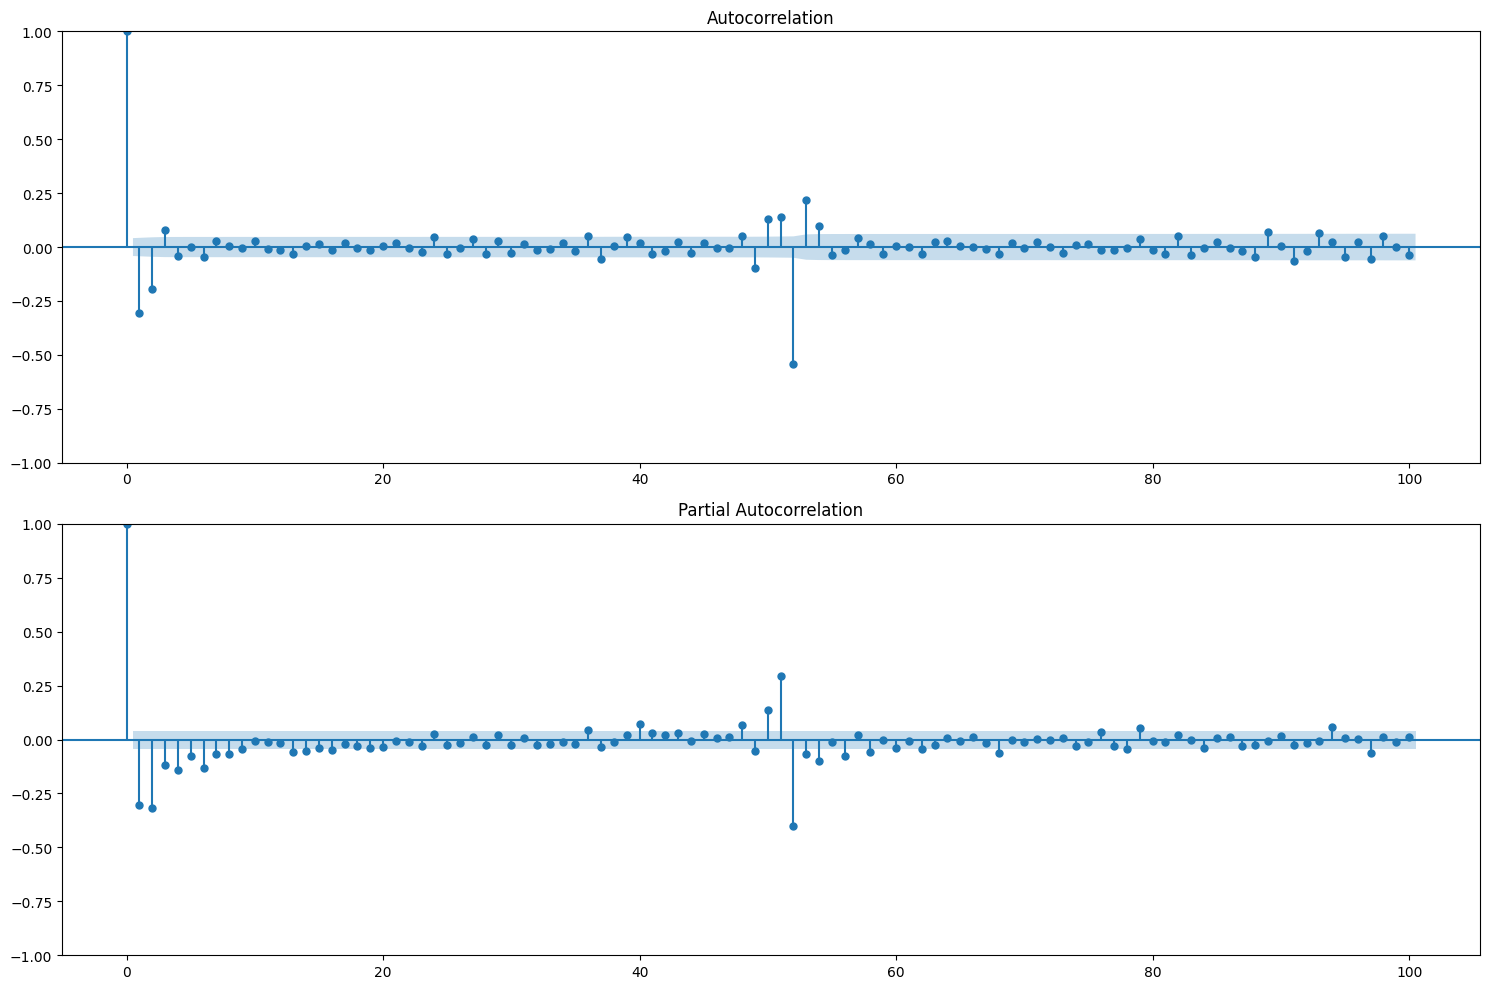

In [149]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
plot_acf(co2_diff1, lags=100, ax=axes[0])
plot_pacf(co2_diff1, lags=100, ax=axes[1])
fig.tight_layout()

In [152]:
result1 = adfuller(co2_diff1)
print("p-value:", result1[1])


p-value: 5.192500390755284e-28


In [ ]:
# now the dataset is stationary

                                     SARIMAX Results                                      
Dep. Variable:                                co2   No. Observations:                 2284
Model:             SARIMAX(2, 0, 0)x(1, 1, 0, 52)   Log Likelihood               -1532.199
Date:                            Fri, 07 Nov 2025   AIC                           3072.397
Time:                                    22:02:07   BIC                           3095.240
Sample:                                03-29-1958   HQIC                          3080.738
                                     - 12-29-2001                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7058      0.018     39.875      0.000       0.671       0.740
ar.L2          0.2746      0.018   

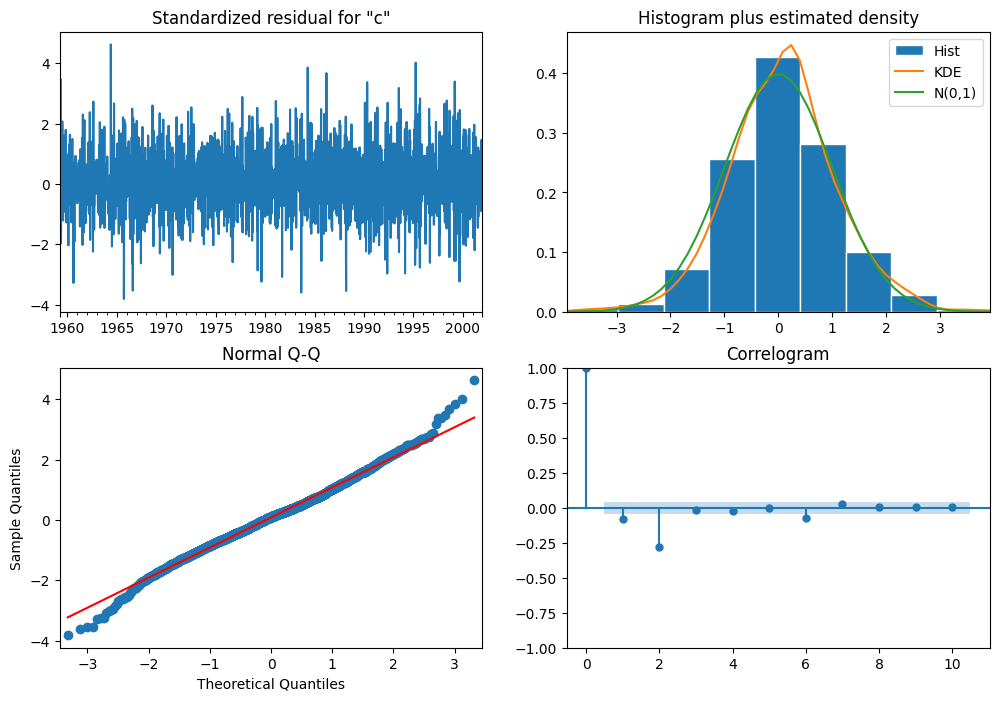

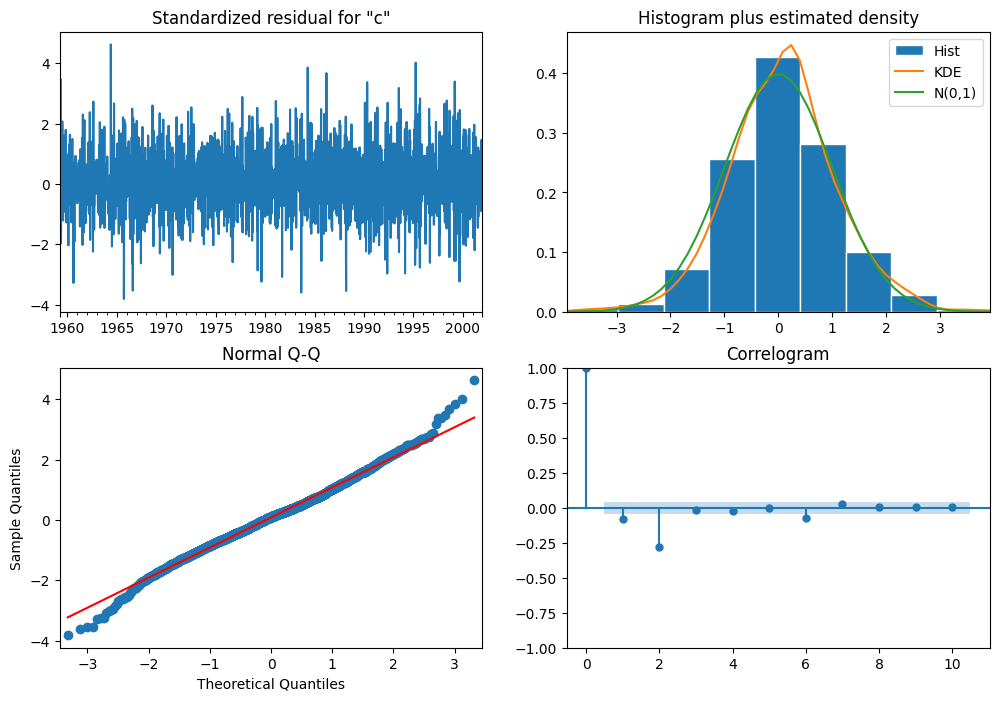

In [146]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(co2, order=(2,0,0), seasonal_order=(1,1,0,52))
result = model.fit()
print(result.summary())
result.plot_diagnostics(figsize=(12, 8))